# Import and Cleaning

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime
from functions import remove_high_corr, scale_variables, best_params_grid,\
    calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label,get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split,\
    cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,\
    make_scorer, balanced_accuracy_score, f1_score, matthews_corrcoef

## Load data

In [2]:
data = pd.read_csv("/home/gustavo/github/mestrado/reworks/models/oral_vs_non_oral/data/fda_padel_pre_processed.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,0.106
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786


## Separating X and Y matrices, and Test and Train

In [3]:
Y = data['oral']
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [4]:
X = data.iloc[:, 14:]
X.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,nS,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,0.0,-0.4695,0.220430,11.1997,8.393965,0.0,0.0,3.0,0.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.646
1,0.0,-1.0852,1.177659,15.4305,9.557965,0.0,0.0,1.0,2.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-0.728
2,0.0,-1.0880,1.183744,12.5072,8.231172,0.0,0.0,2.0,2.0,0.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,6.081016e-02,1.216203e-02,1.237595e+01,2.475191,0.0,-1.606
3,0.0,-0.2157,0.046526,22.3381,12.187551,0.0,0.0,1.0,0.0,1.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,0.000000e+00,0.000000e+00,8.452347e+00,2.113087,0.0,0.106
4,0.0,-0.5895,0.347510,11.3934,11.222758,0.0,0.0,0.0,1.0,1.0,...,-1.734723e-18,0.0,8.673617e-19,0.0,1.110223e-16,2.775558e-17,3.000000e+06,750000.000000,0.0,-0.786


In [5]:
np.random.seed(6752)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Scaling datasets

In [6]:
# Train
x_train_scaled = scale_variables(x_train)

# Adding constant to represent the intercept
x_train_scaled = sm.add_constant(x_train_scaled)
x_train_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,-0.431568,1.094133,-0.179643,1.377595,0.492227,-1.287102,-0.053243,-1.108594,0.414918,...,1.215029,1.120995,0.680183,1.021898,-0.787477,-0.933327,-0.146560,-0.158609,1.218152,-0.127751
1,1.0,1.022405,0.777846,-0.260589,-1.049034,-0.691683,0.533237,-0.053243,-0.634965,-0.544410,...,0.134458,-0.055471,-1.533795,-1.243185,-0.940941,-0.966153,-0.146726,-0.158659,-0.974418,0.693993
2,1.0,-0.431568,0.686693,-0.274695,-0.796842,-0.048617,1.140017,-0.053243,-0.634965,-1.183961,...,-0.482542,-0.371812,0.248796,-0.100341,-0.315508,-0.380355,-0.146635,-0.158628,-0.974418,2.328956
3,1.0,-0.431568,0.691445,-0.274061,0.658982,0.001893,-1.287102,-0.053243,-1.108594,-0.224634,...,0.715488,1.377913,2.246740,-1.243185,-0.547167,-0.575556,-0.146604,-0.158586,0.752471,-0.333357
4,1.0,1.022405,0.475701,-0.291515,1.085786,0.432537,-1.287102,-0.053243,-1.108594,0.414918,...,0.911058,0.505363,0.843524,1.021365,0.816226,0.597733,-0.146171,-0.158307,0.752471,-0.106269


In [7]:
# Test
x_test_scaled = scale_variables(x_test)
x_test_scaled = sm.add_constant(x_test_scaled)
x_test_scaled.head()

,const,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nB,nN,nO,...,JGI7,JGI8,JGI9,JGI10,VE1_D,VE2_D,VR1_D,VR2_D,SRW5,XLogP
0,1.0,-0.353498,0.393712,-0.290299,-1.113592,-0.783941,0.448199,-0.065233,-0.741017,0.570155,...,0.394945,0.735331,2.601364,-1.196476,-0.010453,0.280563,-0.157827,-0.147265,-1.009413,0.547104
1,1.0,-0.353498,0.702783,-0.253077,0.793641,0.018145,-1.437833,-0.065233,-1.232253,-0.479701,...,0.975259,0.772934,2.052936,0.467010,0.086085,0.198956,-0.157660,-0.147191,0.688491,0.229902
2,1.0,-0.353498,-1.834325,0.936660,2.573952,3.834779,2.334230,-0.065233,-0.249781,3.019820,...,0.275175,-0.177609,0.292579,0.602205,-1.112815,-1.222799,2.540790,0.352553,-1.009413,1.230157
3,1.0,-0.353498,-0.639529,-0.047860,0.253726,0.000854,-0.494817,-0.065233,0.241455,0.570155,...,-0.547427,0.252496,0.718428,1.026141,0.931846,0.922152,-0.157706,-0.147236,0.688491,-1.266328
4,1.0,1.149664,0.294704,-0.291535,-0.636573,-1.394817,-1.437833,-0.065233,-0.741017,-0.479701,...,-2.339300,-1.794189,-1.513883,-1.196476,-0.596011,0.343421,-0.157953,-0.147285,-1.009413,-2.022946


In [8]:
print(f"Train shape {x_train_scaled.shape}, Test shape: {x_test_scaled.shape}")

Train shape (1415, 582), Test shape: (472, 582)


In [9]:
# Creating dataframe to store final results
final_results = pd.DataFrame(
    columns=[
        "model_name",
        "cv_test_auc",
        "training_mis_rate",
        "test_mis_rate",
        "training_auc",
        "test_auc",
        "balanced_acc_test",
        "mcc_train",
        "mcc_test"
    ]
)

# Logistic regression

## CV

In [10]:
# model params of logit
model_params_lr = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1500),
        'params': {
            'solver':['lbfgs', 'liblinear'],
            'C': [-1, 0, 1],
            'penalty': ['l1', 'l2', 'elasticnet', 'None']

        }
    }
}

gs_results_lr, gs_results_lr_full = best_params_grid(x_train_scaled, y_train, model_params_lr)
print(gs_results_lr)

Starting Grid Search for LogisticRegression: 00:34


/home/gustavo/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
252 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gustavo/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gustavo/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/gustavo/miniforge3/envs/teachopencadd/lib/python3.8/site-packages/sklearn/base.py",

Finished Grid Search for LogisticRegression: 00:35
Tempo de execução:  0.4 minutos
                model  best_score  \
0  LogisticRegression    0.644821   

                                        best_params  
0  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}  


## Fitting the model

In [11]:
lr_params = gs_results_lr.iloc[0,2]
print(gs_results_lr)

                model  best_score  \
0  LogisticRegression    0.644821   

                                        best_params  
0  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}  


In [12]:
logistic = LogisticRegression(**lr_params, max_iter=500).fit(x_train_scaled, y_train)

## Training Error and AUC

In [ ]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=logistic,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1654
Training AUC: 0.8084


## Make predictions


In [14]:
y_predict_lr_label = logistic.predict(x_test_scaled)
y_predict_lr_prob = logistic.predict_log_proba(x_test_scaled)[:,1]

## Tes Error and AUC

In [15]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_lr_label
)

Misclassification rate: 0.3623


Text(0.5, 1.0, 'Confusion Matrix: Logistic Regression \nOral vs Non Oral')

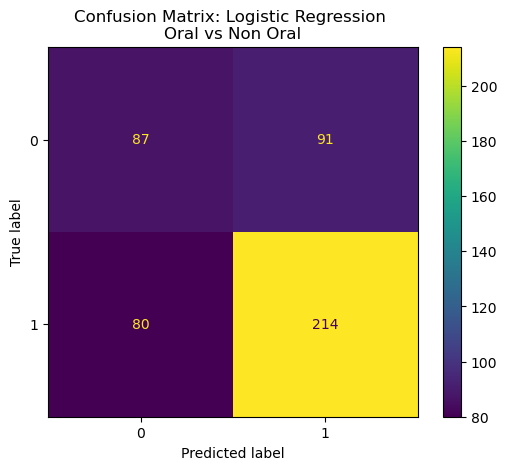

In [16]:
disp.plot()
plt.title(f"Confusion Matrix: Logistic Regression \nOral vs Non Oral")

## ROC/AUC


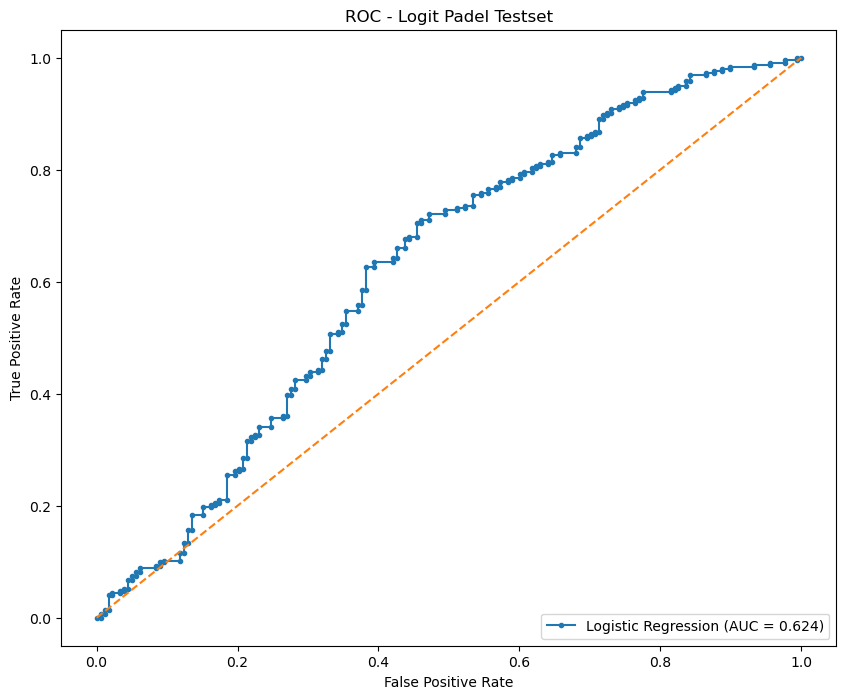

In [17]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name="Logistic Regression",
    title=f"ROC - Logit Padel Testset",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/logistic_padel_total.png"
)

## Feature Importance


In [18]:
print(len(logistic.coef_[0]))

582


## Results

In [ ]:
balanced_acc_test_lr = balanced_accuracy_score(y_test, y_predict_lr_label)
mcc_test_lr = matthews_corrcoef(y_test, y_predict_lr_label)
mcc_train_lr = matthews_corrcoef(y_train, logistic.predict(x_train_scaled))

print(f"Balanced ACC test set {balanced_acc_test_lr}, \n\
      MCC test set {mcc_test_lr} MCC train set {mcc_train_lr}")

final_results.loc[len(final_results.index)] = [
    'Logistic Regression',
    gs_results_lr['best_score'][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr,
    balanced_acc_test_lr,
    mcc_train_lr,
    mcc_test_lr
]

final_results

Balanced ACC test set 0.6083276007032026, 
      MCC test set 0.21960621716242454 MCC train set 0.6426604976874296


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic Regression,0.644821,0.165371,0.362288,0.808422,0.624475,0.608328,0.64266,0.219606


# Decision Tree


## Hyperparameter Tuning


In [20]:
dt_model_params = {
    'Decision Tree':{
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [4,8,10],
            'ccp_alpha': [0, 0.0001, 0.001]
        }
    }
}

In [21]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train_scaled, y_train, dt_model_params)
gs_result_dt

Starting Grid Search for Decision Tree: 00:35
Finished Grid Search for Decision Tree: 00:36
Tempo de execução:  1.4 minutos


,model,best_score,best_params
0,Decision Tree,0.605054,"{'ccp_alpha': 0.001, 'criterion': 'entropy', '..."


In [22]:
gs_result_dt.iloc[0,2]

{'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 4}

## Fitting tree

In [23]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train_scaled, y_train)

## Training Error and AUC

In [24]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.2813
Training AUC: 0.6537


## Predictions

In [25]:
y_predict_dt_label = decision_tree.predict(x_test_scaled)
y_predict_dt_prob = decision_tree.predict_proba(x_test_scaled)[:,1]

## Test errors

In [26]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_dt_label
)

Misclassification rate: 0.3983


Text(0.5, 1.0, 'CM Decision Tree \n Oral vs Non Oral')

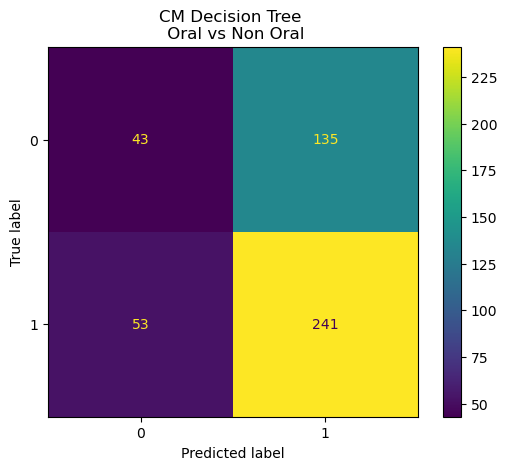

In [27]:
disp.plot()
plt.title(f"CM Decision Tree \n Oral vs Non Oral")

## ROC AUC Test set

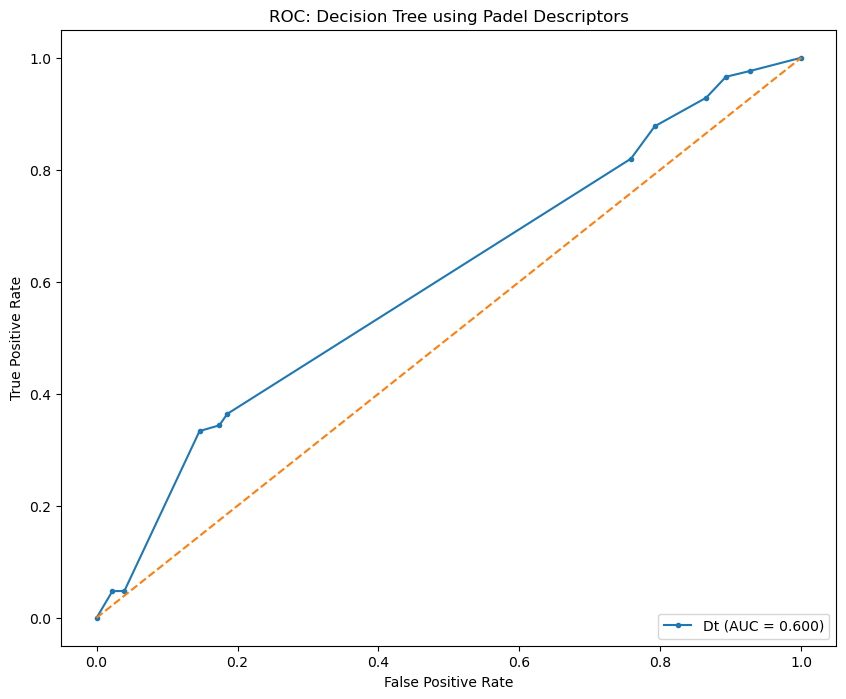

In [28]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name="Dt",
    title='ROC: Decision Tree using Padel Descriptors',
    save_path=f'/home/gustavo/github/mestrado/reworks/imgs/dt_padel_total.png'
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Decision Trees \n Oral vs Non Oral, Padel Descriptors')

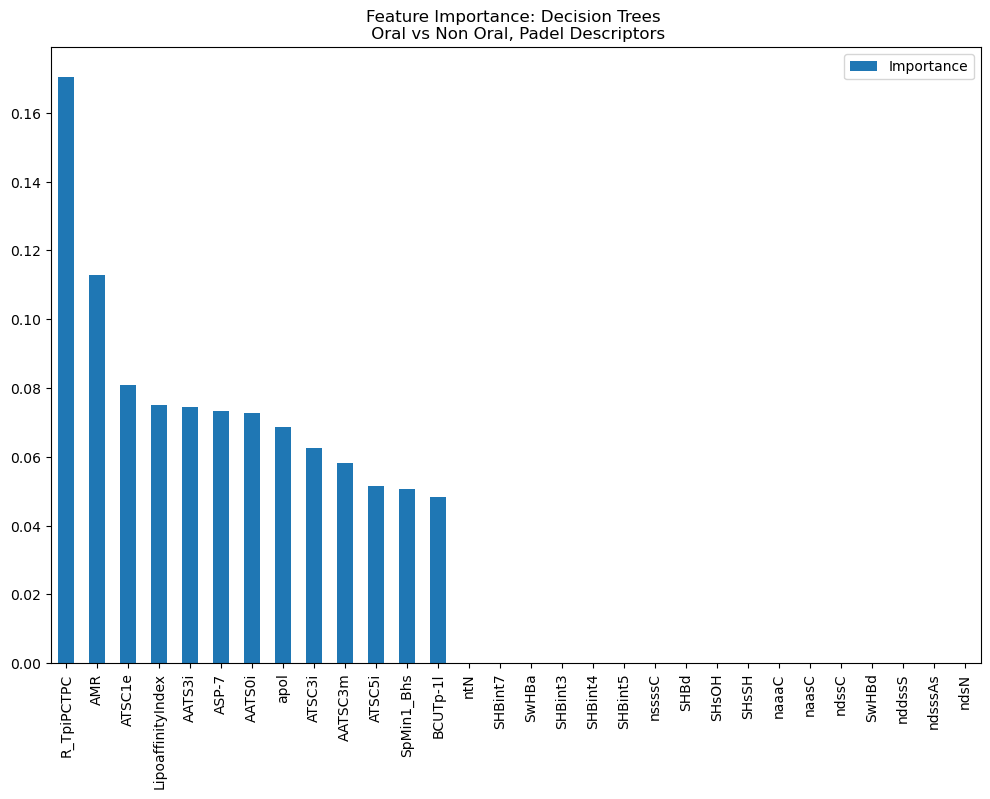

In [29]:
# print the feature importances
fix, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    decision_tree.feature_importances_,
    index=x_train_scaled.columns,
    columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30, :].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance: Decision Trees \n Oral vs Non Oral, Padel Descriptors")

In [30]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by='Importance',
                                                                                      ascending=False)
important_features_dt 

,Importance
R_TpiPCTPC,0.170543
AMR,0.112764
ATSC1e,0.080771
LipoaffinityIndex,0.075091
AATS3i,0.074625
ASP-7,0.073351
AATS0i,0.072680
apol,0.068673
ATSC3i,0.062692
AATSC3m,0.058246


## Results

In [31]:
balanced_acc_test_dt = balanced_accuracy_score(y_test, y_predict_dt_label)
mcc_train_dt = matthews_corrcoef(y_train, decision_tree.predict(x_train_scaled))
mcc_test_dt = matthews_corrcoef(y_test, y_predict_dt_label)

print( f"Balanced ACC test set: \
      {balanced_acc_test_dt} \nMCC train {mcc_train_dt}, \nMCC test {mcc_test_dt}")


final_results.loc[len(final_results.index)] = [
    "Decision Tree",
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt,
    balanced_acc_test_dt,
    mcc_train_dt,
    mcc_test_dt
]
final_results

Balanced ACC test set:       0.5306504624321638 
MCC train 0.3756378108353692, 
MCC test 0.07381101105204821


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic Regression,0.644821,0.165371,0.362288,0.808422,0.624475,0.608328,0.642660,0.219606
1,Decision Tree,0.605054,0.281272,0.398305,0.653685,0.600359,0.530650,0.375638,0.073811


# Random Forest and Bagging

Training Misclassification Rate: 0.1986
Training AUC: 0.7443
Misclassification rate: 0.3136


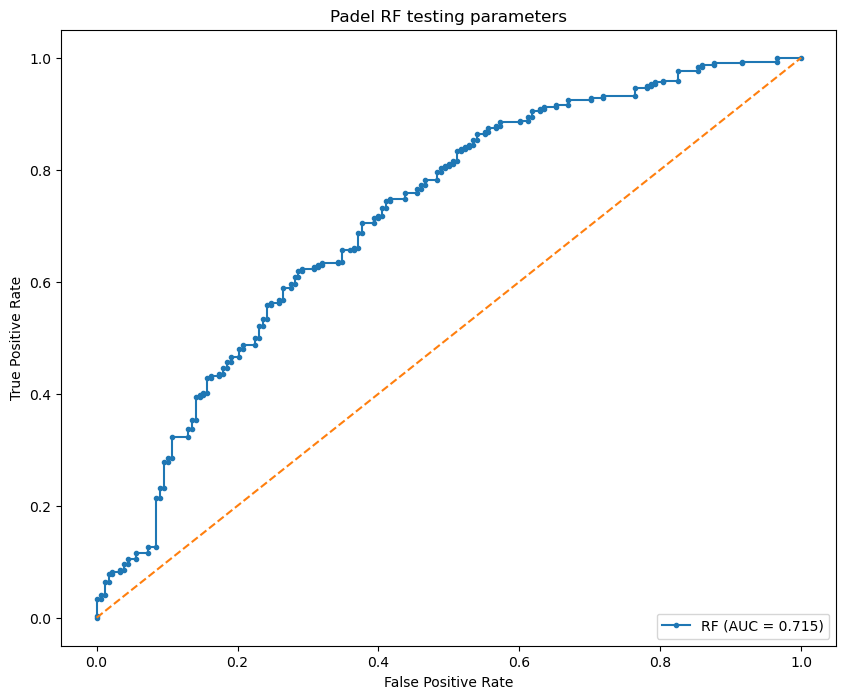

In [32]:
# Testing
rf_model_params_test = {'max_depth':10, 'ccp_alpha':0.005, 'min_samples_split':15}
rf_test = RandomForestClassifier(**rf_model_params_test).fit(x_train_scaled, y_train)

# make predictions
y_predict_rf_label_test = rf_test.predict(x_test_scaled)
y_predict_rf_prob_test = rf_test.predict_proba(x_test_scaled)[:,1]

mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=rf_test,
    x=x_train_scaled,
    y_true=y_train
)

# Test error
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label_test
)

auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob_test,
    model_name='RF',
    title=f"Padel RF testing parameters",
    save_path="/home/gustavo/github/mestrado/reworks/imgs/random_forest_test.png"
)

In [33]:
# Hyperparameter finetuning

rf_model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'max_depth': [10],
            'max_features': ['sqrt', x_train_scaled.shape[0]],
            'ccp_alpha':[0.005],
            'min_samples_split':[15]
        }
    }
}

In [34]:
gs_results_rf, gs_results_rf_full = best_params_grid(x_train_scaled, y_train, rf_model_params)

Starting Grid Search for Random Forest: 00:36
Finished Grid Search for Random Forest: 00:42
Tempo de execução:  6.3 minutos


In [35]:
gs_results_rf

,model,best_score,best_params
0,Random Forest,0.697725,"{'ccp_alpha': 0.005, 'max_depth': 10, 'max_fea..."


## Fitting the model

In [36]:
random_forest_params = gs_results_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0.005,
 'max_depth': 10,
 'max_features': 1415,
 'min_samples_split': 15}

In [37]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train_scaled, y_train)

## Make predictions

In [38]:
y_predict_rf_label = random_forest.predict(x_test_scaled)
y_predict_rf_prob = random_forest.predict_proba(x_test_scaled)[:,1]

## Get Training Error and AUC

In [39]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest,
    x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1223
Training AUC: 0.8434


## Test error

In [40]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_rf_label
)

Misclassification rate: 0.3051


Text(0.5, 1.0, 'Confusion Matrix: Random Forest\n Oral vs Non Oral, PaDeL')

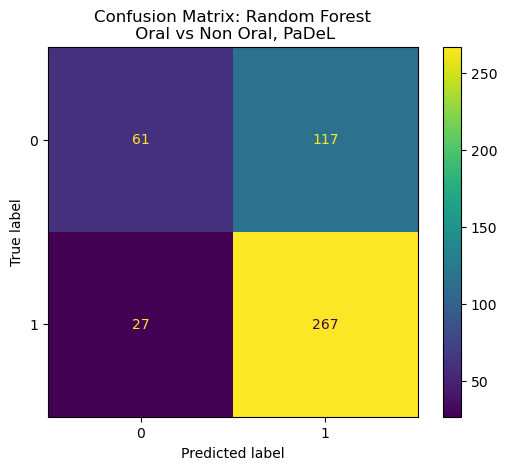

In [41]:
disp.plot()
plt.title(f"Confusion Matrix: Random Forest\n Oral vs Non Oral, PaDeL")

## ROC/AUC

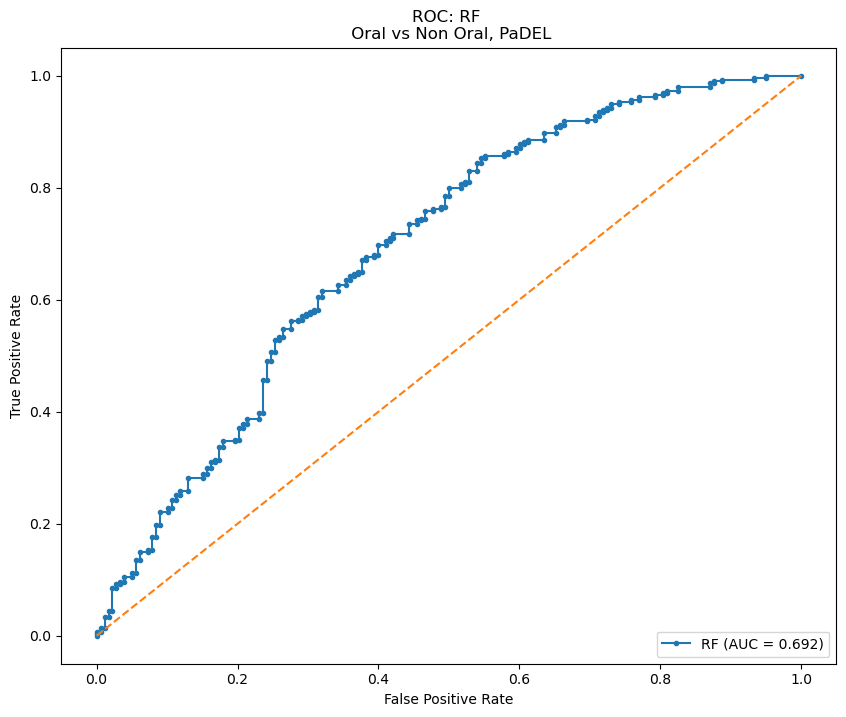

In [42]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name='RF',
    title=f"ROC: RF \n Oral vs Non Oral, PaDEL",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_padel_rf.png"
)

## Feature Importance

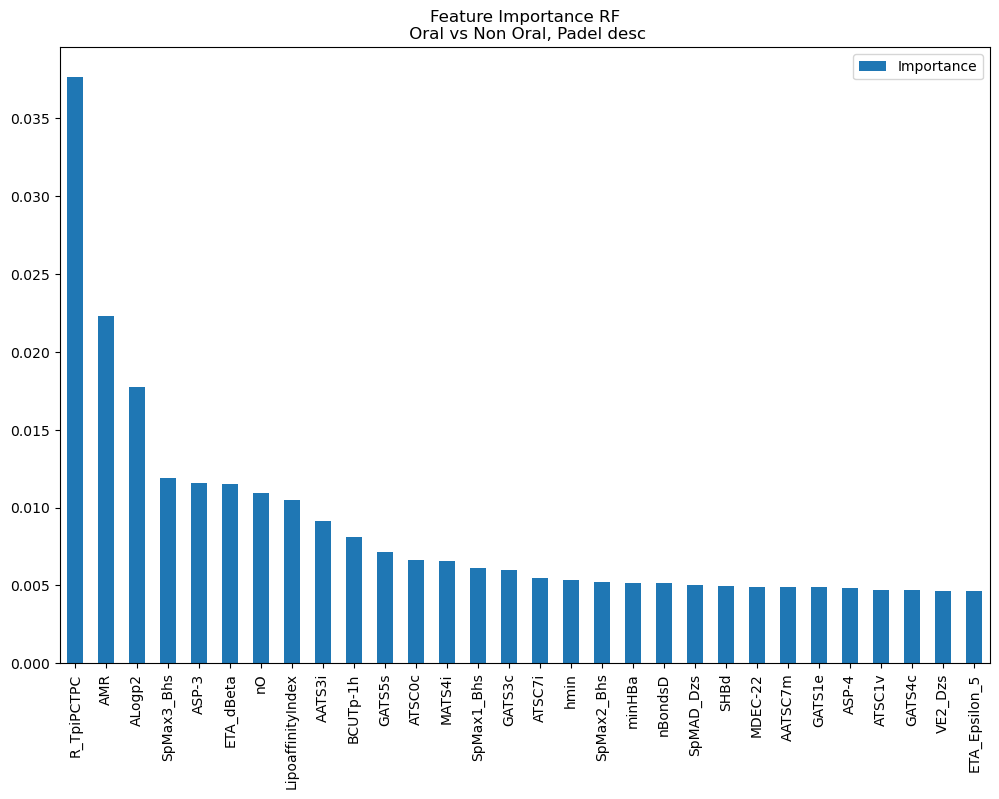

In [43]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(random_forest.feature_importances_,
                                index=x_train_scaled.columns,
                                columns=['Importance'])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30,:].plot(kind='bar', figsize=(12,8), ax=ax)
ax.set_title(f"Feature Importance RF\n Oral vs Non Oral, Padel desc")
fig.savefig(f"/home/gustavo/github/mestrado/reworks/imgs/feature_importance_rf_padel.png")

In [44]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(
    by='Importance', ascending=False
)
important_features_rf[0:30]

,Importance
R_TpiPCTPC,0.037668
AMR,0.022312
ALogp2,0.017735
SpMax3_Bhs,0.011894
ASP-3,0.011597
ETA_dBeta,0.011505
nO,0.010920
LipoaffinityIndex,0.010509
AATS3i,0.009111
BCUTp-1h,0.008116


## Saving Results

In [45]:
balanced_acc_test_rf = balanced_accuracy_score(y_test, y_predict_rf_label)
mcc_train_rf = matthews_corrcoef(y_train, random_forest.predict(x_train_scaled))
mcc_test_rf = matthews_corrcoef(y_test, y_predict_rf_label)

print(f"Balanced ACC test set {balanced_acc_test_rf}\
      \nMCC train set: {mcc_train_rf}, MCC test set {mcc_test_rf}")

final_results.loc[len(final_results.index)] = [
    'Random Forest',
    gs_results_rf['best_score'][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf,
    balanced_acc_test_rf,
    mcc_train_rf,
    mcc_test_rf
]

final_results

Balanced ACC test set 0.6254299472598028      
MCC train set: 0.7454424544166709, MCC test set 0.31218206815984323


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic Regression,0.644821,0.165371,0.362288,0.808422,0.624475,0.608328,0.642660,0.219606
1,Decision Tree,0.605054,0.281272,0.398305,0.653685,0.600359,0.530650,0.375638,0.073811
2,Random Forest,0.697725,0.122261,0.305085,0.843447,0.692368,0.625430,0.745442,0.312182


# Gradient Boosting

Training Misclassification Rate: 0.1385
Training AUC: 0.8168
Misclassification rate: 0.3093


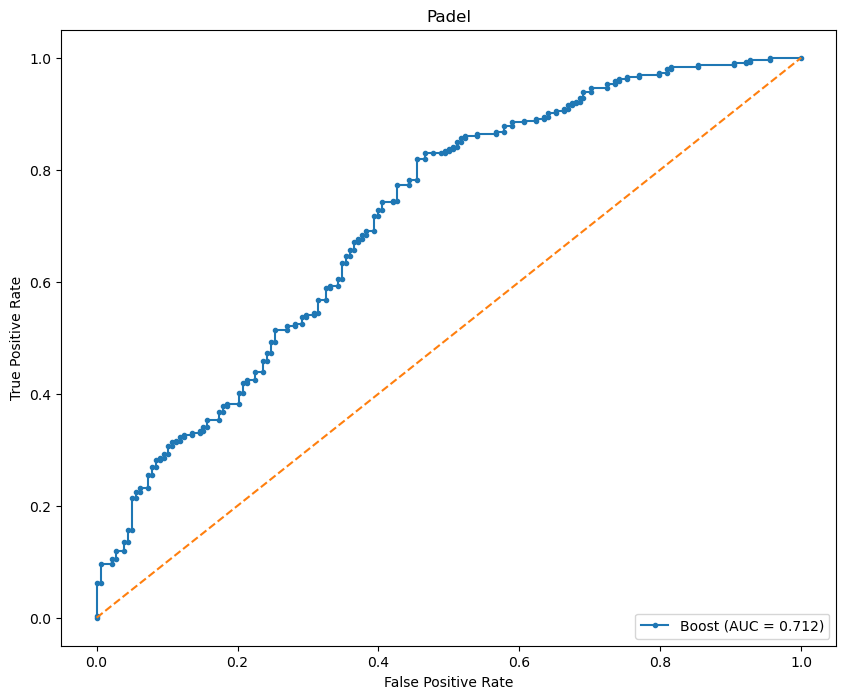

In [46]:
# Testing
gradient_boost_test_params = {
    'max_depth':9,
    'min_samples_split':20,
    'max_features':'sqrt',
    'learning_rate':0.01,
    'subsample':0.6
}

boost_test = GradientBoostingClassifier(**gradient_boost_test_params).fit(x_train_scaled, y_train)


# make predictions
y_predict_boost_label_test = boost_test.predict(x_test_scaled)
y_predict_boost_prob_test = boost_test.predict_proba(x_test_scaled)[:,1]

mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boost_test,
    x=x_train_scaled,
    y_true=y_train
)

# Test error
mis_rate_boost_test, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label_test
)

auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob_test,
    model_name='Boost',
    title=f'Padel',
    save_path='/home/gustavo/github/mestrado/reworks/imgs/boost_test.png'
)

In [47]:
boosting_model_params = {
    'Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'learning_rate': [0.01],
            'max_depth': [9],
            'min_samples_split':[21],
            'subsample':[0.6]
        }
    }
}

In [48]:
gs_result_boost, gs_result_boost_full = best_params_grid(x_train_scaled, y_train, boosting_model_params)
gs_result_boost

Starting Grid Search for Boosting: 00:43
Finished Grid Search for Boosting: 00:48
Tempo de execução:  4.4 minutos


,model,best_score,best_params
0,Boosting,0.707246,"{'learning_rate': 0.01, 'max_depth': 9, 'min_s..."


## Fitting the model

In [49]:
boosting_params = gs_result_boost.iloc[0,2]
print(boosting_params)
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train_scaled, y_train)

{'learning_rate': 0.01, 'max_depth': 9, 'min_samples_split': 21, 'subsample': 0.6}


## Training Error and AUC

In [50]:
mis_rate_boost_train, auc_boost_train = get_error_and_auc(
    model=boosting,
    x=x_train_scaled,
    y_true=y_train,
)

Training Misclassification Rate: 0.0919
Training AUC: 0.8785


## Make predictions

In [51]:
y_predict_boost_label = boosting.predict(x_test_scaled)
y_predict_boost_prob = boosting.predict_proba(x_test_scaled)[:,1]

## Test error

In [52]:
mis_rate_boost, disp = calculate_confusion_matrix(
    y_test=y_test,
    y_pred=y_predict_boost_label
)

Misclassification rate: 0.3030


Text(0.5, 1.0, 'CM: Gradient Boosting \n Oral vs Non Oral, ')

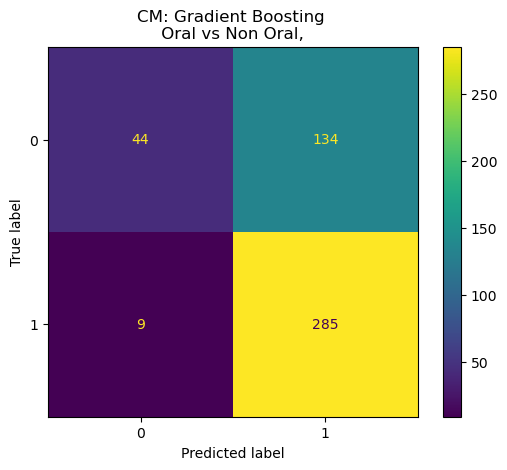

In [53]:
disp.plot()
plt.title(f"CM: Gradient Boosting \n Oral vs Non Oral, ")

## ROC/AUC

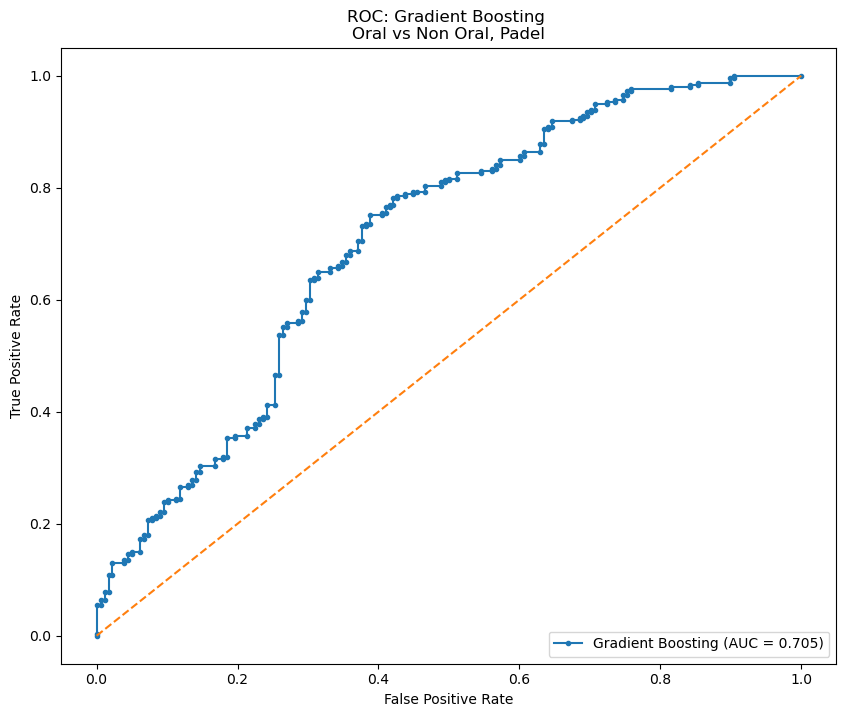

In [54]:
auc_boost = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boost_prob,
    model_name='Gradient Boosting',
    title=f"ROC: Gradient Boosting \nOral vs Non Oral, Padel",
    save_path=f"/home/gustavo/github/mestrado/reworks/imgs/roc_auc_padel_gb.png"
)

## Feature Importance

Text(0.5, 1.0, 'Feature Importance: Gradient Boosting \n Oral vs Non Oral, Padel')

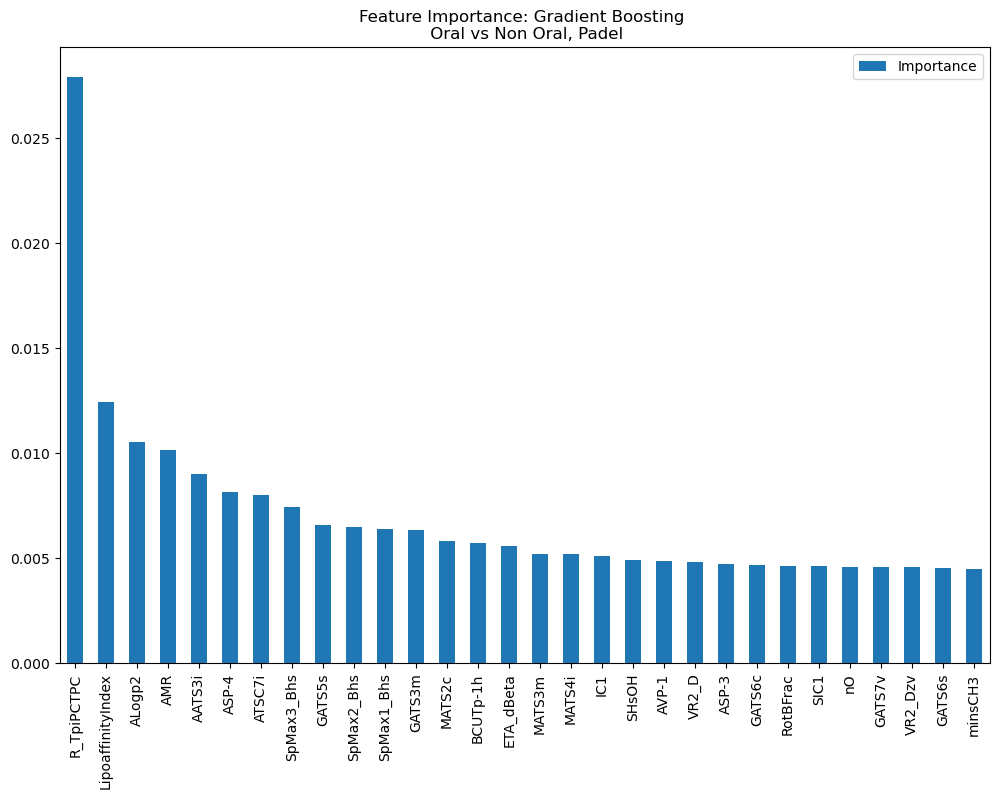

In [55]:
fig, ax = plt.subplots(1,1)
feat_importances = pd.DataFrame(
    boosting.feature_importances_,
    index=x_train_scaled.columns, columns=['Importance']
)
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.iloc[:30, :].plot(kind='bar', figsize=(12,8), ax = ax)

ax.set_title(f'Feature Importance: Gradient Boosting \n Oral vs Non Oral, Padel')

In [56]:
important_features_boost = feat_importances[feat_importances.Importance >0].sort_values(
    by='Importance', ascending=False
)
important_features_boost[0:30]

,Importance
R_TpiPCTPC,0.027923
LipoaffinityIndex,0.012415
ALogp2,0.010536
AMR,0.010169
AATS3i,0.009005
ASP-4,0.008135
ATSC7i,0.008027
SpMax3_Bhs,0.007428
GATS5s,0.006578
SpMax2_Bhs,0.006469


## Saving Results

In [57]:
balanced_acc_test_boost = balanced_accuracy_score(y_test, y_predict_boost_label)
mcc_train_boost = matthews_corrcoef(y_train, boosting.predict(x_train_scaled))
mcc_test_boost = matthews_corrcoef(y_test, y_predict_boost_label)

print(f"Balanced ACC test set {balanced_acc_test_boost}, MCC test set: {mcc_test_boost}\
      MCC train set {mcc_train_boost}")

final_results.loc[len(final_results.index)] = [
    "Gradient Boosting",
    gs_result_boost['best_score'][0],
    mis_rate_boost_train,
    mis_rate_boost,
    auc_boost_train,
    auc_boost,
    balanced_acc_test_boost,
    mcc_train_boost,
    mcc_test_boost
]

Balanced ACC test set 0.6082893831689979, MCC test set: 0.3324716323312215      MCC train set 0.8121406893549943


In [58]:
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic Regression,0.644821,0.165371,0.362288,0.808422,0.624475,0.608328,0.642660,0.219606
1,Decision Tree,0.605054,0.281272,0.398305,0.653685,0.600359,0.530650,0.375638,0.073811
2,Random Forest,0.697725,0.122261,0.305085,0.843447,0.692368,0.625430,0.745442,0.312182
3,Gradient Boosting,0.707246,0.091873,0.302966,0.878505,0.705133,0.608289,0.812141,0.332472


# SVM

## Hyperpameter Tuning

In [59]:
svm_model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.2, 1, 2,4],
            'kernel':['rbf','sigmoid'],
            'gamma':['auto', 0.0001, 0.001]
        }
    }
}

In [60]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train_scaled, y_train, svm_model_params)


Starting Grid Search for SVM: 00:48
Finished Grid Search for SVM: 00:51
Tempo de execução:  2.6 minutos


## Fitting the model

In [61]:
gs_result_svm
svm_params = gs_result_svm.iloc[0,2]
print(svm_params)

{'C': 2, 'gamma': 'auto', 'kernel': 'rbf'}


In [62]:
svm = SVC(**svm_params, probability=True).fit(x_train_scaled, y_train)

## Training Error and AUC

In [63]:
miss_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, x=x_train_scaled,
    y_true=y_train
)

Training Misclassification Rate: 0.1300
Training AUC: 0.8343


## Make prediction

In [64]:
y_predict_svm_label = svm.predict(x_test_scaled)
y_predict_svm_prob = svm.predict_proba(x_test_scaled)[:,1]

## Test Error


In [65]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test= y_test,
    y_pred=y_predict_svm_label
)

Misclassification rate: 0.2881


Text(0.5, 1.0, 'COnfusion Matrix SVM\nOral vs Non Oral, Padel')

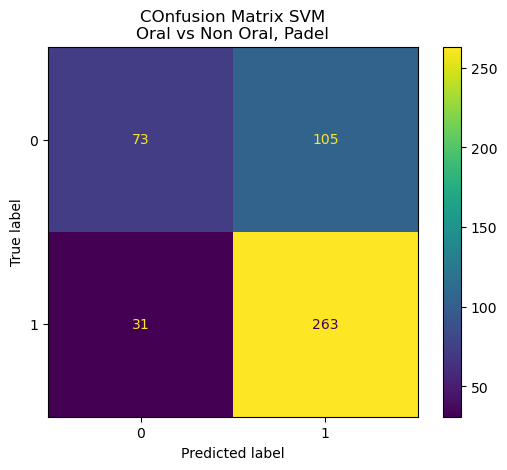

In [66]:
disp.plot()
plt.title(f"COnfusion Matrix SVM\nOral vs Non Oral, Padel")

## ROC/AUC

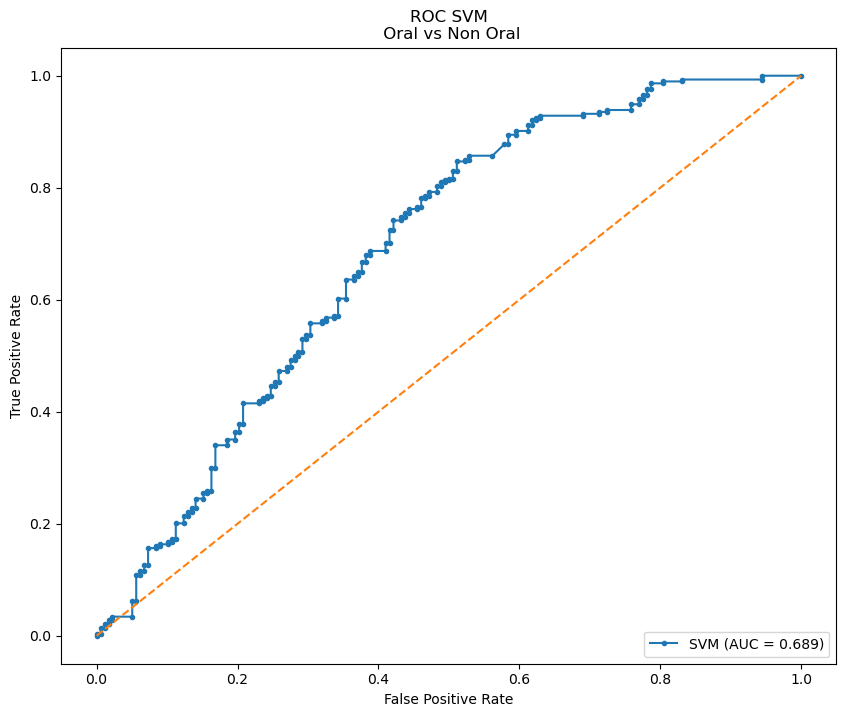

In [67]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name='SVM',
    title=f"ROC SVM\n Oral vs Non Oral",
    save_path='/home/gustavo/github/mestrado/reworks/imgs/roc_auc_padel_svm.png'
)

## Save Results

In [68]:
balanced_acc_test_svm = balanced_accuracy_score(y_test, y_predict_svm_label)
mcc_train_svm = matthews_corrcoef(y_train, svm.predict(x_train_scaled))
mcc_test_svm = matthews_corrcoef(y_test, y_predict_svm_label)



print(f"Balanced ACC test set {balanced_acc_test_svm}, MCC train set: {mcc_train_svm} MCC test set: {mcc_test_svm}")
final_results.loc[len(final_results.index)] = [
    "SVM",
    gs_result_svm["best_score"][0],
    miss_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm,
    balanced_acc_test_svm,
    mcc_train_svm,
    mcc_test_svm
]
final_results

Balanced ACC test set 0.6523350913399067, MCC train set: 0.7284363934817718 MCC test set: 0.35626490289806934


,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc,balanced_acc_test,mcc_train,mcc_test
0,Logistic Regression,0.644821,0.165371,0.362288,0.808422,0.624475,0.608328,0.642660,0.219606
1,Decision Tree,0.605054,0.281272,0.398305,0.653685,0.600359,0.530650,0.375638,0.073811
2,Random Forest,0.697725,0.122261,0.305085,0.843447,0.692368,0.625430,0.745442,0.312182
3,Gradient Boosting,0.707246,0.091873,0.302966,0.878505,0.705133,0.608289,0.812141,0.332472
4,SVM,0.703285,0.130035,0.288136,0.834266,0.688795,0.652335,0.728436,0.356265
